# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 8

In [3]:
# path = untar_data(URLs.PETS)/'images'
path = Path('/data/fastai/oxford-iiit-pet/images')

## Data augmentation

In [4]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [5]:
doc(get_transforms)

In [6]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [7]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [8]:
data = get_data(224, bs, 'zeros')

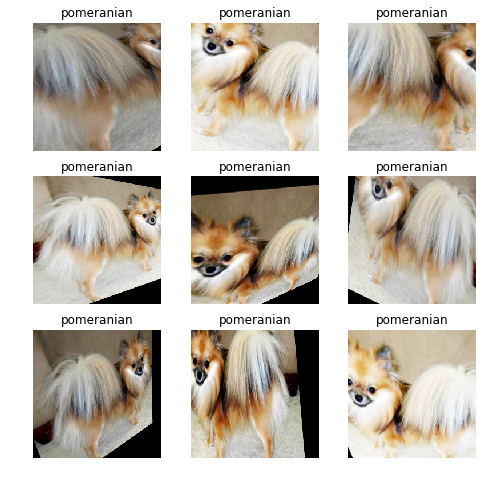

In [9]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [10]:
data = get_data(224,bs)

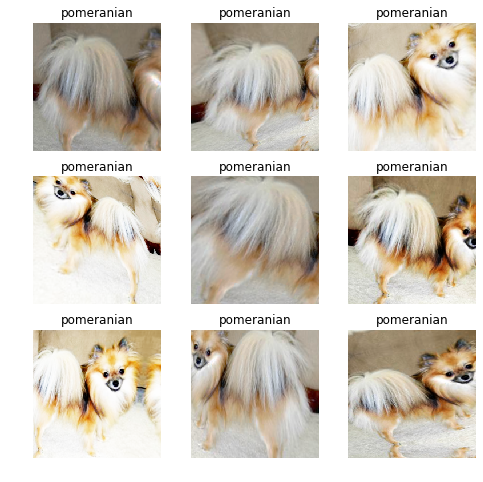

In [11]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [17]:
gc.collect()
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [18]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,2.199454,1.061320,0.144790
2,1.281070,0.318356,0.085927
3,1.028902,0.240049,0.065629


In [19]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,0.914760,0.241475,0.061570
2,0.855533,0.231042,0.066306


In [20]:
data = get_data(352,bs)
learn.data = data

In [21]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,1.317997,0.211276,0.054804
2,1.216826,0.205837,0.058863


In [22]:
learn.save('352')

## Convolution kernel

In [259]:
data = get_data(352,bs)

In [260]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category basset_hound

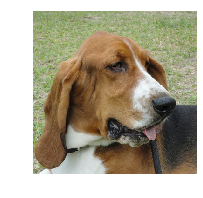

In [261]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [262]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [263]:
tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).shape

torch.Size([3, 3])

In [264]:
k.shape

torch.Size([1, 3, 3, 3])

In [265]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [266]:
tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(3,3,3)

tensor([[[ 0.0000, -1.6667,  1.0000],
         [-1.6667, -1.6667,  1.0000],
         [ 1.0000,  1.0000,  1.0000]],

        [[ 0.0000, -1.6667,  1.0000],
         [-1.6667, -1.6667,  1.0000],
         [ 1.0000,  1.0000,  1.0000]],

        [[ 0.0000, -1.6667,  1.0000],
         [-1.6667, -1.6667,  1.0000],
         [ 1.0000,  1.0000,  1.0000]]])

In [267]:
tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1, 3,3,3)

tensor([[[[ 0.0000, -1.6667,  1.0000],
          [-1.6667, -1.6667,  1.0000],
          [ 1.0000,  1.0000,  1.0000]],

         [[ 0.0000, -1.6667,  1.0000],
          [-1.6667, -1.6667,  1.0000],
          [ 1.0000,  1.0000,  1.0000]],

         [[ 0.0000, -1.6667,  1.0000],
          [-1.6667, -1.6667,  1.0000],
          [ 1.0000,  1.0000,  1.0000]]]])

In [268]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [269]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [270]:
edge = F.conv2d(t[None], k)

In [271]:
F.conv2d??

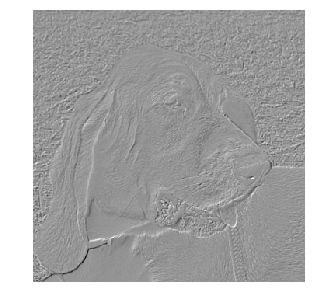

In [272]:
show_image(edge[0], figsize=(5,5));

In [273]:
k2 = tensor([
    [0.  ,-5/3,1],
    [1.  ,1   ,1],
    [-5/3,-5/3,1],
]).expand(1,3,3,3)/6

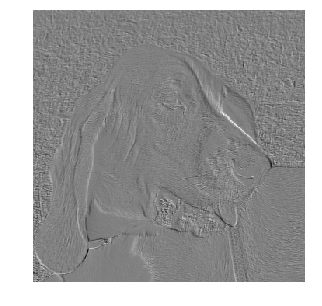

In [274]:
show_image(F.conv2d(t[None], k2)[0], figsize=(5,5));

In [275]:
data.c

37

In [276]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [277]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 64, 176, 176]    9408       False     
______________________________________________________________________
BatchNorm2d          [8, 64, 176, 176]    128        True      
______________________________________________________________________
ReLU                 [8, 64, 176, 176]    0          False     
______________________________________________________________________
MaxPool2d            [8, 64, 88, 88]      0          False     
______________________________________________________________________
Conv2d               [8, 64, 88, 88]      36864      False     
______________________________________________________________________
BatchNorm2d          [8, 64, 88, 88]      128        True      
______________________________________________________________________
ReLU                 [8, 64, 88, 88]      0          False     
______________________________________________________________

## Heatmap

In [278]:
m = learn.model.eval();

In [279]:
type(m)

torch.nn.modules.container.Sequential

In [280]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [281]:
type(x), type(xb), type(xb_im)

(fastai.vision.image.Image, torch.Tensor, fastai.vision.image.Image)

In [282]:
xb.shape

torch.Size([1, 3, 352, 352])

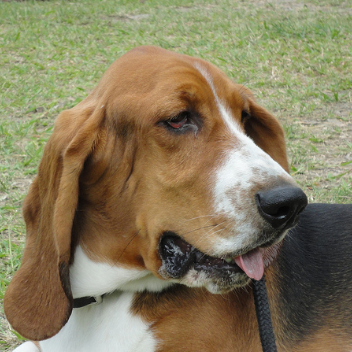

In [283]:
x

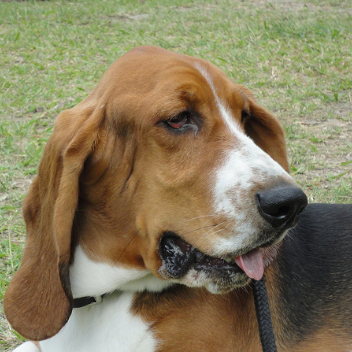

In [284]:
xb_im

In [285]:
from fastai.callbacks.hooks import *

In [286]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [287]:
type(y), y

(fastai.core.Category, Category basset_hound)

In [288]:
len(m), [len(o) for o in m]

(2, [8, 10])

In [289]:
hook_a,hook_g = hooked_backward()

In [290]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [291]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [292]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

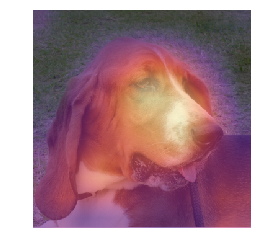

In [293]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [321]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [322]:
grad.mean(1).shape, grad.mean(1).mean(1).shape

(torch.Size([512, 11]), torch.Size([512]))

In [323]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [324]:
grad_chan.mean()

tensor(-0.0000)

In [325]:
acts.shape, grad_chan[...,None,None].shape, (acts*grad_chan[...,None,None]).shape, mult.shape

(torch.Size([512, 11, 11]),
 torch.Size([512, 1, 1]),
 torch.Size([512, 11, 11]),
 torch.Size([11, 11]))

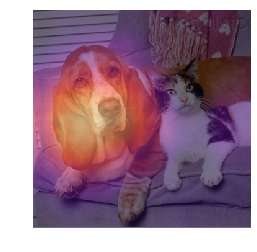

In [326]:
show_heatmap(mult)

In [327]:
!wget https://www.kimballstock.com/pr/112817970/KimballStock_DOK-03-RK0069-07_preview.jpg -P $path/../other/

--2019-02-11 19:00:33--  https://www.kimballstock.com/pr/112817970/KimballStock_DOK-03-RK0069-07_preview.jpg
Resolving www.kimballstock.com (www.kimballstock.com)... 216.47.168.91
Connecting to www.kimballstock.com (www.kimballstock.com)|216.47.168.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54427 (53K) [text/html]
Saving to: ‘/data/fastai/oxford-iiit-pet/images/../other/KimballStock_DOK-03-RK0069-07_preview.jpg.2’

KimballStock_DOK-03 100%[===================>]  53.15K  --.-KB/s    in 0.03s   

2019-02-11 19:00:34 (1.60 MB/s) - ‘/data/fastai/oxford-iiit-pet/images/../other/KimballStock_DOK-03-RK0069-07_preview.jpg.2’ saved [54427/54427]



In [328]:
ls /data/fastai/oxford-iiit-pet/other

10-tips-for-bringing-dogs-and-cats-together0.jpg
10-tips-for-bringing-dogs-and-cats-together2.jpg
516438-istock-637689912.jpg
KimballStock_DOK-03-RK0069-07_preview.jpg
KimballStock_DOK-03-RK0069-07_preview.jpg.1
KimballStock_DOK-03-RK0069-07_preview.jpg.2


In [329]:
fn = path/'../other/KimballStock_DOK-03-RK0069-07_preview.jpg' #Replace with your own image

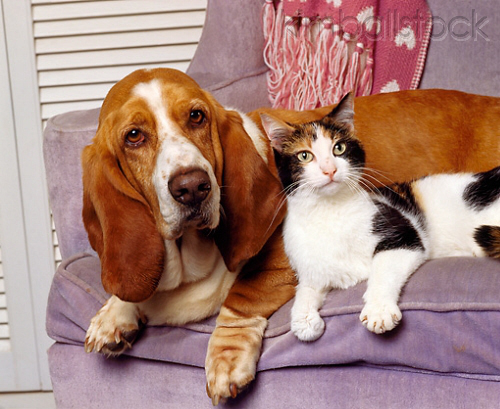

In [330]:
x = open_image(fn); x

In [304]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [305]:
data.classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [318]:
hook_a,hook_g = hooked_backward(data.classes.index('basset_hound'))

In [319]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

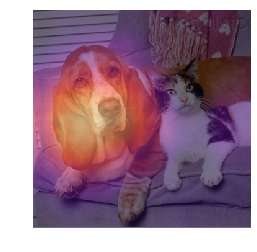

In [320]:
show_heatmap(mult)

In [315]:
hook_a,hook_g = hooked_backward(data.classes.index('Maine_Coon'))

In [316]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

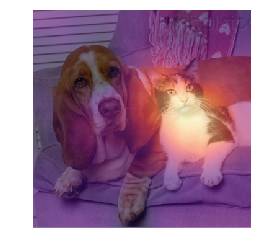

In [317]:
show_heatmap(mult)

## fin